In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib
matplotlib.style.use('seaborn')

from draftbot import Draft
from itertools import repeat

In [2]:
draft = Draft()
drafters = draft.draft()

In [3]:
drafter = drafters[0]

In [4]:
def make_archytype_color_mapping(alpha):
    arch_color_mapping = {
        'W': [1, 0.8, 0.5, alpha],
        'U': [0, 0, 1, alpha],
        'B': [0.2, 0.2, 0.2, alpha],
        'R': [1, 0, 0, alpha],
        'G': [0, 0.8, 0, alpha]
    }
    return arch_color_mapping

def make_archytype_colors(arch, alpha=1):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    return [arch_color_mapping[c] for c in arch]

In [5]:
def plot_alternating_color_line(ax, x, y, colors):
    x, y = insert_middpoints(x.astype(float)), insert_middpoints(y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    segment_boundaries = insert_middpoints(np.arange(x.min(), x.max() + 1))
    n_bins = len(segment_boundaries) - 1
    cmap = ListedColormap((colors*n_bins)[:n_bins])
    norm = BoundaryNorm(segment_boundaries, cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)

def insert_middpoints(arr):
    midpoints = (arr[:-1] + arr[1:]) / 2
    return np.insert(arr, np.arange(1, len(arr)), midpoints)

In [6]:
def plot_color_identity_dot(ax, x, y, color_identity, alpha=1.0):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    colors = [arch_color_mapping[c] for c in color_identity]
    if len(colors) == 0:
        ax.scatter(x, y, c=['grey'], s=100, zorder=2)
    if len(colors) == 1:
        ax.scatter(x, y, c=[colors[0]], s=100, zorder=2)
    if len(colors) >= 2:
        plot_two_color_dot(ax, x, y, colors)

def plot_two_color_dot(ax, x, y, colors):
    angles = list(np.linspace(start=0, stop=2*np.pi, num=(len(colors) + 1)))
    begin_angles = angles[:-1]
    end_angles = angles[1:]
    for angle, end_angle, color in zip(begin_angles, end_angles, colors):
        xs = [0] + np.sin(np.linspace(angle, end_angle, 25)).tolist()
        ys = [0] + np.cos(np.linspace(angle, end_angle, 25)).tolist()
        xy = np.column_stack([xs, ys])
        ax.scatter(x, y, marker=(xy, 0), s=100, facecolor=color, zorder=2)

In [7]:
def plot_drafter_history(ax, drafter):
    history_df = pd.DataFrame(drafter._archytype_preferences_history)
    history_df = pd.DataFrame(
        np.exp(history_df).values 
        / np.exp(history_df).sum(axis=1).values.reshape(-1, 1),
        columns=history_df.columns)
    card_colors = [card['colorIdentity'] for card in drafter.cards]

    winning_archytype = history_df.iloc[-1, :].idxmax()
    winning_history = history_df.loc[:, winning_archytype]

    colors = make_archytype_colors(winning_archytype, alpha=1.0)
    plot_alternating_color_line(
        ax, winning_history.index.values, 
        winning_history.values, 
        colors)

    for arch in set(history_df.columns) - set([winning_archytype]):
        arch_history = history_df.loc[:, arch]
        colors = make_archytype_colors(arch, alpha=0.2)
        plot_alternating_color_line(
            ax,
            arch_history.index.values,
            arch_history.values, colors)

    for color_pair, x, y in zip(card_colors, 
                                winning_history.index.values + 1, 
                                winning_history.values[1:]):
        plot_color_identity_dot(ax, x, y, color_pair)    

    ax.set_xlim(-1, 37)
    ax.set_ylim(0, 1.1)

/Users/matthewdrury/anaconda3/lib/python3.7/site-packages/matplotlib/markers.py:380: MatplotlibDeprecationWarning: 
Passing vertices as `(verts, 0)` is deprecated since Matplotlib 3.0, and support for it will be removed in 3.2.  Directly pass `verts` instead.
  "3.0", "Passing vertices as `(verts, 0)` is deprecated since "


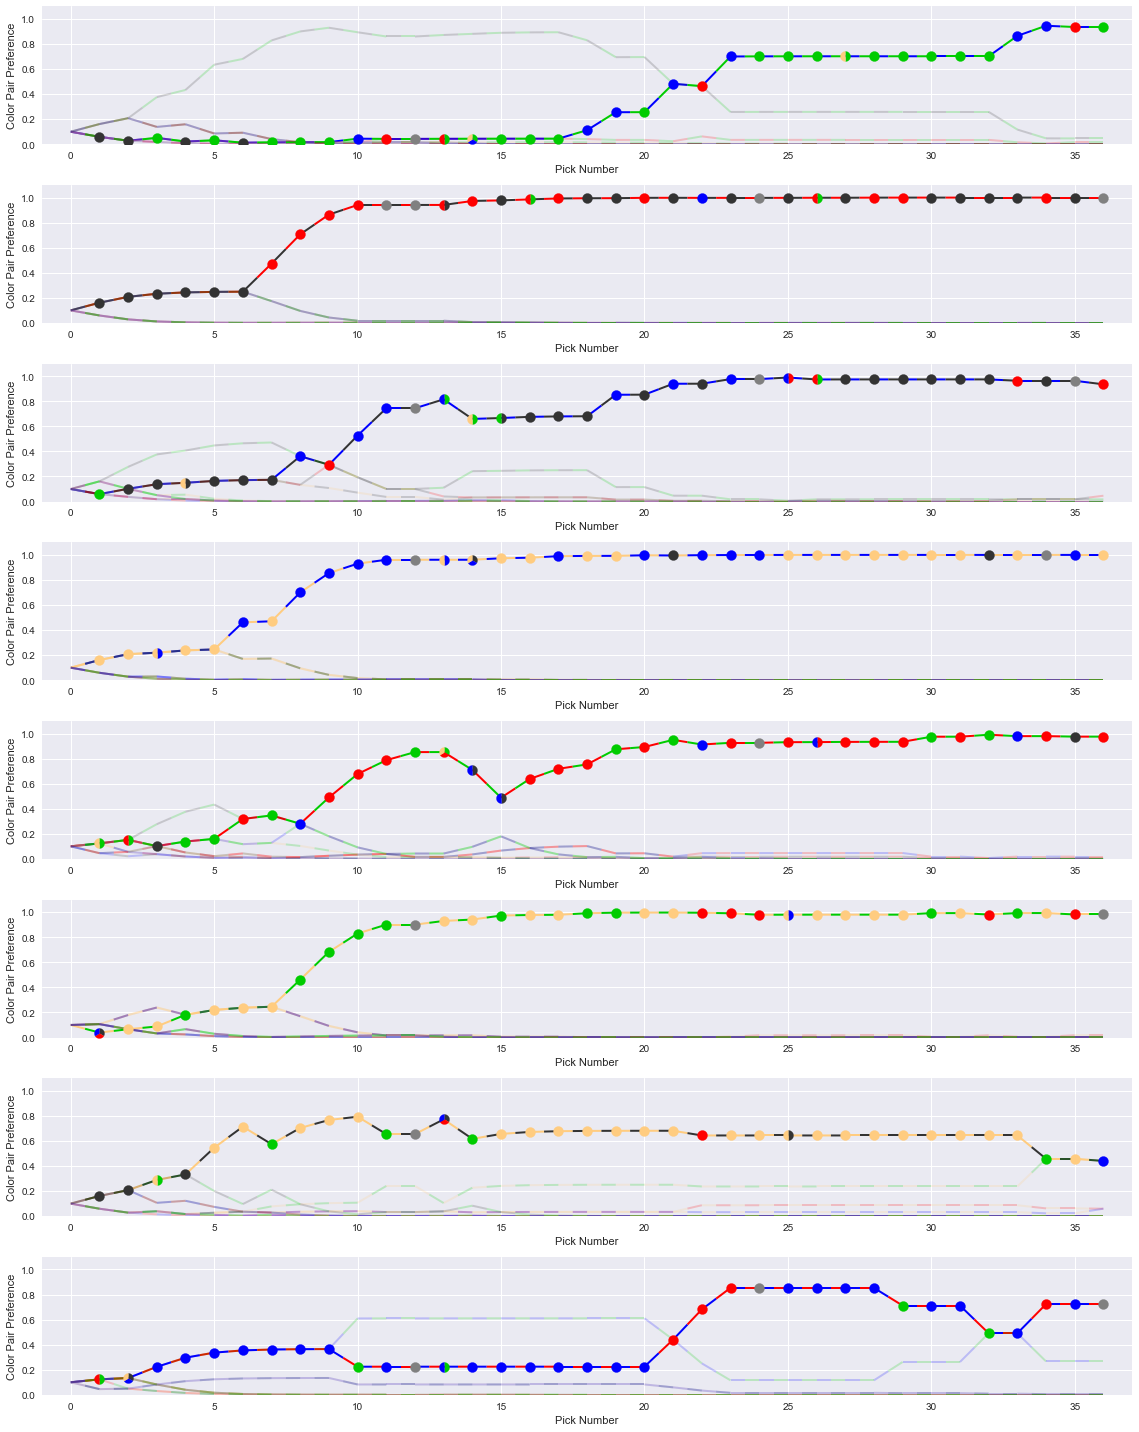

In [8]:
fig, axs = plt.subplots(8, 1, figsize=(16, 20))

for ax, drafter in zip(axs, drafters):
    plot_drafter_history(ax, drafter)
    ax.set_xlabel("Pick Number")
    ax.set_ylabel("Color Pair Preference")
fig.tight_layout()